# Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
    return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [74]:
class Chromosome:
    def __init__(
        self, length, array=None
    ):  # if array is None it should be initialized with random binary vector
        self.length = length
        if array is not None:
            self.array = array
        else:
            self.array = np.random.randint(0, 2, length)
        

    def decode(self, lower_bound, upper_bound, aoi):
        bits_per_argument = upper_bound - lower_bound
        cut_array = self.array[lower_bound:upper_bound]
        value = int("".join(str(i) for i in cut_array.astype(int)), 2)
        normalized_value = min_max_norm(
            value, 0, 2**bits_per_argument - 1, aoi[0], aoi[1]
        )
        return normalized_value

    def mutation(self, probability):
        will_mutate = np.random.random_sample() <= probability
        if will_mutate:
            index = np.random.choice(np.arange(0, self.length))
            self.array[index] = 1 - self.array[index]

    def crossover(self, other):
        index = np.random.choice(np.arange(1, self.length-1))
        children = (
            Chromosome(
                self.length,
                array=np.concatenate((self.array[:index], other.array[index:])),
            ),
            Chromosome(
                self.length,
                array=np.concatenate((other.array[:index], self.array[index:])),
            ),
        )
        return children

In [75]:
# Test
chromosome_one = Chromosome(8, np.array([1, 0, 0, 0, 0, 1, 1, 1]))
chromosome_two = Chromosome(8, np.array([0, 1, 1, 1, 0, 1, 1, 0]))
chromosome_one.crossover(chromosome_two)

(<__main__.Chromosome at 0x21332fa35b0>,
 <__main__.Chromosome at 0x21332fa2cb0>)

In [76]:
class GeneticAlgorithm:
    def __init__(
        self,
        chromosome_length,
        obj_func_num_args,
        objective_function,
        aoi,
        population_size=1000,
        tournament_size=2,
        mutation_probability=0.05,
        crossover_probability=0.8,
        num_steps=30,
    ):
        assert (
            chromosome_length % obj_func_num_args == 0
        ), "Number of bits for each argument should be equal"
        self.chromosome_length = chromosome_length
        self.obj_func_num_args = obj_func_num_args
        self.bits_per_arg = int(chromosome_length / obj_func_num_args)
        self.objective_function = objective_function
        self.aoi = aoi
        create_pupulation = np.vectorize(Chromosome)
        self.population_size = population_size
        self.population = create_pupulation(np.full(population_size, chromosome_length))
        self.tournament_size = tournament_size
        self.mutation_probability = mutation_probability
        self.crossover_probability = crossover_probability
        self.num_steps = num_steps

    def eval_objective_func(self, chromosome):
        decoded_values = np.zeros(self.obj_func_num_args)
        for i in range(0, self.obj_func_num_args):
            lower_bound = i * self.bits_per_arg
            upper_bound = lower_bound + self.bits_per_arg
            decoded_values[i] = chromosome.decode(lower_bound, upper_bound, self.aoi)
        evaluation = self.objective_function(*decoded_values)
        return evaluation

    def tournament_selection(self):
        selected_chromosomes = np.random.choice(
            self.population, size=self.tournament_size, replace=True
        )
        evaluate_selected_chromosomes = np.vectorize(self.eval_objective_func)
        evaluation = evaluate_selected_chromosomes(selected_chromosomes)
        best_chromosome = selected_chromosomes[np.argmin(evaluation)]
        return best_chromosome

    def reproduce(self, parents):
        new_population = np.zeros(len(parents), dtype=Chromosome)
        for i in range(len(parents)):
            new_population[i] = self.tournament_selection()
            if i % 2 == 1:
                will_crossover = np.random.random_sample() <= self.crossover_probability
                if will_crossover:
                    (new_population[i - 1], new_population[i]) = new_population[
                        i - 1
                    ].crossover(new_population[i])
                new_population[i - 1].mutation(self.mutation_probability)
                new_population[i].mutation(self.mutation_probability)
        return new_population

    def plot_func(self, trace):
        X = np.arange(-2, 3, 0.05)
        Y = np.arange(-4, 2, 0.05)
        X, Y = np.meshgrid(X, Y)
        Z = (
            1.5
            - np.exp(-(X ** (2)) - Y ** (2))
            - 0.5 * np.exp(-((X - 1) ** (2)) - (Y + 2) ** (2))
        )
        plt.figure()
        plt.contour(X, Y, Z, 10)
        cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
        plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
        plt.show()

    def run(self):
        step = 0
        best_evaluations = np.zeros(self.num_steps + 1)
        trace = np.zeros(shape=(self.num_steps + 1, 2))
        evaluate = np.vectorize(self.eval_objective_func)
        evaluation = evaluate(self.population)
        i = np.argmin(evaluation)
        best_evaluations[step] = evaluation[i]
        trace[step][0] = self.population[i].decode(0, self.bits_per_arg, self.aoi)
        trace[step][1] = self.population[i].decode(
            self.bits_per_arg, self.bits_per_arg * 2, self.aoi
        )
        print(
            f"Best point at the beginning: {trace[step]}; Its evaluation: {best_evaluations[step]}",
        )
        step = step + 1
        while step <= self.num_steps:
            self.population = self.reproduce(self.population)
            evaluate = np.vectorize(self.eval_objective_func)
            evaluation = evaluate(self.population)
            index_of_best_chromosome = np.argmin(evaluation)
            best_evaluations[step] = evaluation[index_of_best_chromosome]
            trace[step][0] = self.population[index_of_best_chromosome].decode(
                0, self.bits_per_arg, self.aoi
            )
            trace[step][1] = self.population[index_of_best_chromosome].decode(
                self.bits_per_arg, self.bits_per_arg * 2, self.aoi
            )
            if step % 5 == 0:
                print(
                    f"Best point in {step}th generation: {trace[step]}; Its evaluation: {best_evaluations[step]}"
                )
            step = step + 1
        self.plot_func(trace)

In [77]:
def func(*args):
    return (
        1.5
        - np.exp(-args[0] ** 2 - args[1] ** 2)
        - 0.5 * np.exp(-((args[0] - 1) ** 2) - (args[1] + 2) ** 2)
    )





Best point at the beginning: [ 1.47058824 -2.84313725]; Its evaluation: 1.30314749941975
Best point in 5th generation: [ 0.09803922 -0.09803922]; Its evaluation: 0.5130884233332422
Best point in 10th generation: [ 0.09803922 -0.09803922]; Its evaluation: 0.5130884233332422
Best point in 15th generation: [ 0.09803922 -0.09803922]; Its evaluation: 0.5130884233332422
Best point in 20th generation: [ 0.09803922 -0.09803922]; Its evaluation: 0.5130884233332422
Best point in 25th generation: [ 0.09803922 -0.09803922]; Its evaluation: 0.5130884233332422
Best point in 30th generation: [ 0.09803922 -0.09803922]; Its evaluation: 0.5130884233332422


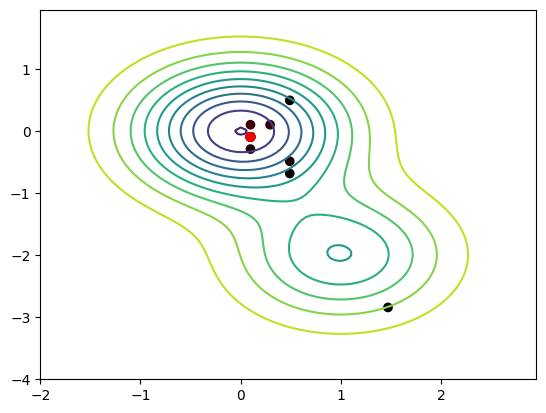

In [78]:
g0 = GeneticAlgorithm(16, 2, func, [-25, 25])
g0.run()

Best point at the beginning: [-2.88367546 -0.53763441]; Its evaluation: 1.4998167289634545
Best point in 5th generation: [ 0.14662757 -1.31964809]; Its evaluation: 1.1765256042728667
Best point in 10th generation: [-0.4398827  -0.34213099]; Its evaluation: 0.7629304493966284
Best point in 15th generation: [ 0.24437928 -0.14662757]; Its evaluation: 0.568906501151969
Best point in 20th generation: [ 0.14662757 -0.04887586]; Its evaluation: 0.5182426641008646
Best point in 25th generation: [ 0.04887586 -0.04887586]; Its evaluation: 0.5002707646002946
Best point in 30th generation: [ 0.04887586 -0.04887586]; Its evaluation: 0.5002707646002946
Best point in 35th generation: [ 0.04887586 -0.04887586]; Its evaluation: 0.5002707646002946
Best point in 40th generation: [ 0.04887586 -0.04887586]; Its evaluation: 0.5002707646002946
Best point in 45th generation: [ 0.04887586 -0.04887586]; Its evaluation: 0.5002707646002946
Best point in 50th generation: [ 0.04887586 -0.04887586]; Its evaluation: 

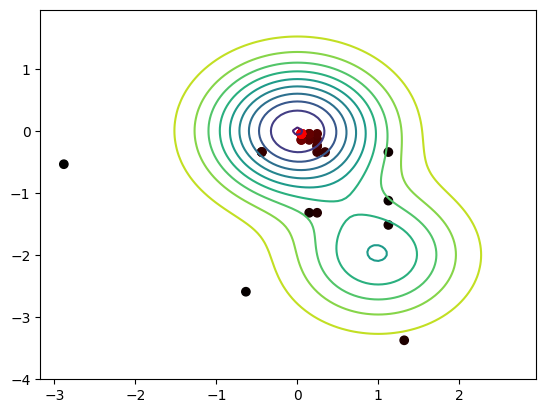

In [79]:
g1 = GeneticAlgorithm(20, 2, func, [-50, 50], population_size=200, num_steps=50)
g1.run()

Best point at the beginning: [0.12707722 1.67155425]; Its evaluation: 1.439809263531645
Best point in 5th generation: [ 0.86999022 -0.61583578]; Its evaluation: 1.1065728050147836
Best point in 10th generation: [ 0.00977517 -0.3030303 ]; Its evaluation: 0.5772931891108781
Best point in 15th generation: [ 0.00977517 -0.3030303 ]; Its evaluation: 0.5772931891108781
Best point in 20th generation: [ 0.00977517 -0.28347996]; Its evaluation: 0.567453425302944
Best point in 25th generation: [ 0.00977517 -0.20527859]; Its evaluation: 0.53386936277814
Best point in 30th generation: [ 0.00977517 -0.20527859]; Its evaluation: 0.53386936277814


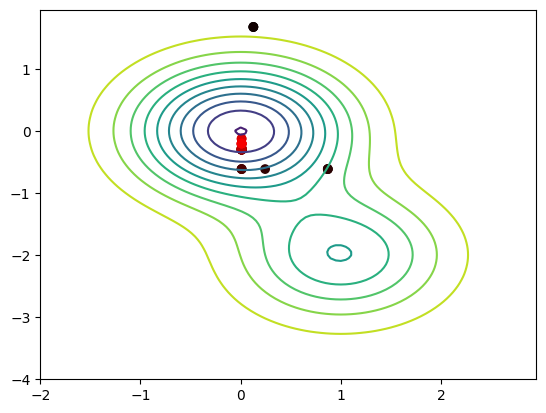

In [80]:
g2 = GeneticAlgorithm(20, 2, func, [-10, 10], population_size=40, num_steps=30)
g2.run()

Best point at the beginning: [-1.21768853 -4.00708029]; Its evaluation: 1.49993488073645
Best point in 5th generation: [-1.35807367  0.91860714]; Its evaluation: 1.4319965959756151
Best point in 10th generation: [ 1.60832545 -1.97454756]; Its evaluation: 1.1533518338870405
Best point in 15th generation: [-0.18616291  0.77822199]; Its evaluation: 0.9728039837307909
Best point in 20th generation: [-0.11291849 -0.05188147]; Its evaluation: 0.512066493328338
Best point in 25th generation: [-0.00305185 -0.00305185]; Its evaluation: 0.4966290909611938
Best point in 30th generation: [-0.00305185 -0.00915555]; Its evaluation: 0.4966200825646027
Best point in 35th generation: [-0.00305185 -0.00915555]; Its evaluation: 0.4966200825646027
Best point in 40th generation: [-0.00305185 -0.00915555]; Its evaluation: 0.4966200825646027


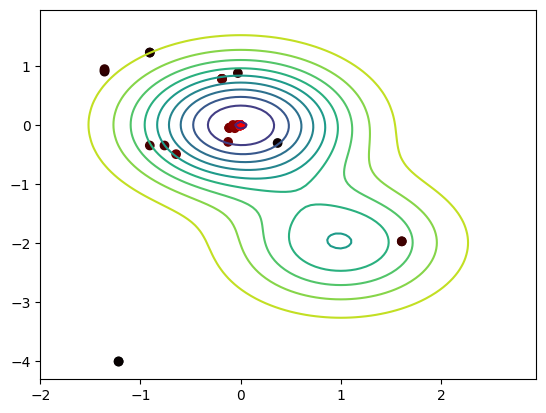

In [81]:
g3 = GeneticAlgorithm(30, 2, func, [-100, 100], num_steps=40)
g3.run()

Best point at the beginning: [-316.18701743   27.93969543]; Its evaluation: 1.5
Best point in 5th generation: [-456.90786462   16.70888394]; Its evaluation: 1.5
Best point in 10th generation: [-171.77343059  385.06729331]; Its evaluation: 1.5
Best point in 15th generation: [-288.59828486 -459.80712302]; Its evaluation: 1.5
Best point in 20th generation: [223.83800775 258.90377514]; Its evaluation: 1.5
Best point in 25th generation: [-161.00039674   26.13910337]; Its evaluation: 1.5
Best point in 30th generation: [-0.32044435  0.10681478]; Its evaluation: 0.6067929979397932
Best point in 35th generation: [-2.45674001  2.18207343]; Its evaluation: 1.4999795395321212
Best point in 40th generation: [ -51.25583666 -349.02493362]; Its evaluation: 1.5
Best point in 45th generation: [ 1.52592547e-02 -4.73632008e+02]; Its evaluation: 1.5
Best point in 50th generation: [-159.71861934 -306.42109439]; Its evaluation: 1.5
Best point in 55th generation: [ 6.05792413 -4.77614673]; Its evaluation: 1.4

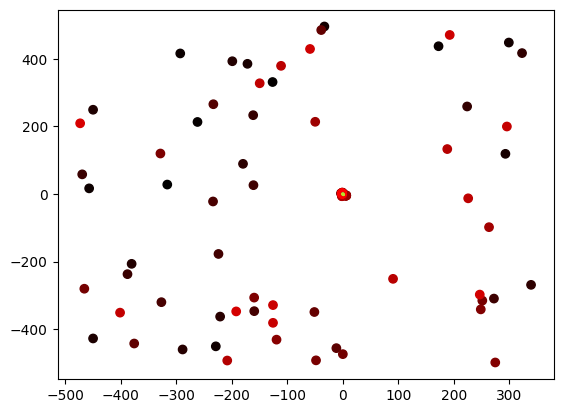

In [82]:
g4 = GeneticAlgorithm(30, 2, func, [-500, 500], num_steps=100)
g4.run()

### Wnioski

Algorytm działa lepiej przy dużym rozmiarze populacji, ze względu na większą liczbę krzyżowań między chromosomami, co prowadzi do zwiększonej szansy na pojawienie się coraz lepszych osobników w kolejnych generacjach. Dobre cechy rodziców mają większą szansę na zostanie przekazanym następnym pokoleniom (np. jeżeli dla powyższej metody skrzyżujemy dwa chromosomy odpowiadające punktom (0.1, -4) i (2, 0), to jednym z ich potomków może być punkt (0.1, 0); mimo że rodzice nie są punktami optymalnymi, ich potomek już jest). Mutacje mogą prowadzić do zgubienia rozwiązania optymalnego, jednak dzięki nim algorytm zwiększa szansę na znalezienie rozwiązania lepszego niż pierwsze minimum lokalne, które algorytm znajdzie, co było niemożliwe w metodzie gradientowej. Jeśli cała populacja znajduje się w pobliżu minimum lokalnego, które nie jest minimum globalnym, negacja jednego bitu chromosomu może prowadzić do opuszczenia obszaru zbiegającego do minimum lokalnego. Jednocześnie selekcja chromosomów rodziców preferuje osobniki o najlepszych właściwościach, dzięki czemu kolejne pokolenia powinny być oceniane lepiej od poprzedników.